
<!-- Título -->
  <h1 style="text-align:center; font-family: Segoe UI, Roboto, Arial, sans-serif; 
             font-weight:800; font-size:2.4rem; letter-spacing:-0.02em; 
             color:#FFFF00; margin:.4rem 0 .6rem;">
    DETECTION OF EYE SOCKETS
  </h1>

### **A) Import libaries**

In [40]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import cv2
#from skimage import exposure

plt.rcParams['figure.figsize'] = [6,6]  #Set default figure size for matplotlib


### **B) DICOMS reading function**

In [41]:
def read_dicom(path):
    archives = [f for f in os.listdir(path) if f.endswith('.dcm')]
    dicoms = [pydicom.dcmread(os.path.join(path, f)) for f in archives]
    dicoms.sort(key=lambda x: int(getattr(x,"InstanceNumber",0)))
    return dicoms

Path = r"C:\Users\Usuario\Documents\Ingeniería Electrónica\CPS\DCM_EYE_SOCKETS\9"

list_dicoms = read_dicom(Path)

print(f"{len(list_dicoms)} DICOM files were uploaded!")

288 DICOM files were uploaded!


### **C) Checking for cuts**

In [42]:

import pydicom.pixel_data_handlers as pdh

print("Is Pillow avaliable?:", pdh.pillow_handler.is_available())
print("Is GDCM avaliable?:", pdh.gdcm_handler.is_available())
print("Is pylibjpeg avaliable?:", pdh.pylibjpeg_handler.is_available())


Is Pillow avaliable?: True
Is GDCM avaliable?: False
Is pylibjpeg avaliable?: True


### **D) Function to display a cut**

In [43]:
def build_volume(dicoms):
    slices = []
    for d in dicoms:
        img = d.pixel_array.astype(np.int16)
        img[img == -2000] = 0

        slope = float(getattr(d, 'RescaleSlope', 1.0))
        intercept = float(getattr(d, 'RescaleIntercept', 0.0))

        img_hu = img * slope + intercept
        slices.append(img_hu)

    volume = np.stack(slices, axis=0)
    return volume

volume = build_volume(list_dicoms)
print("Volumen en HU:", volume.shape, "rango:", np.min(volume), np.max(volume))


Volumen en HU: (288, 512, 512) rango: -1024.0 3071.0


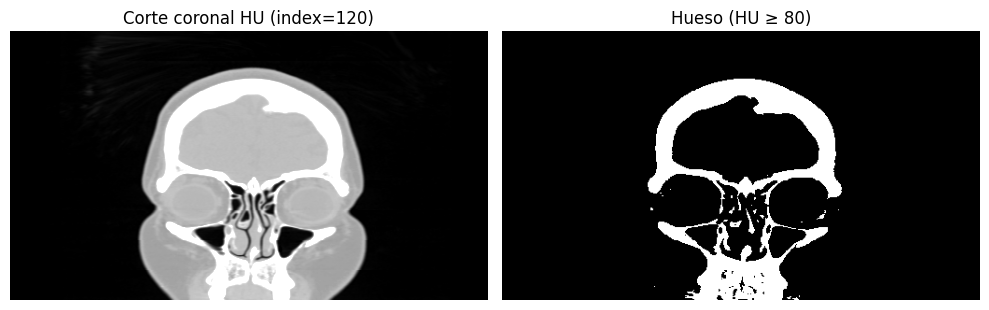

In [44]:
def show_coronal_and_bone(volume, index=100, window=(-1000,400), threshold=1000):
    coronal = np.flipud(volume[:, index, :])
    bone_mask = (coronal >= threshold).astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(coronal, cmap="gray", vmin=window[0], vmax=window[1])
    axes[0].set_title(f"Corte coronal HU (index={index})")
    axes[0].axis("off")

    axes[1].imshow(bone_mask, cmap="gray")
    axes[1].set_title(f"Hueso (HU ≥ {threshold})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Ejemplo
show_coronal_and_bone(volume, index=120, window=(-1000,400), threshold=80)


(147456,)


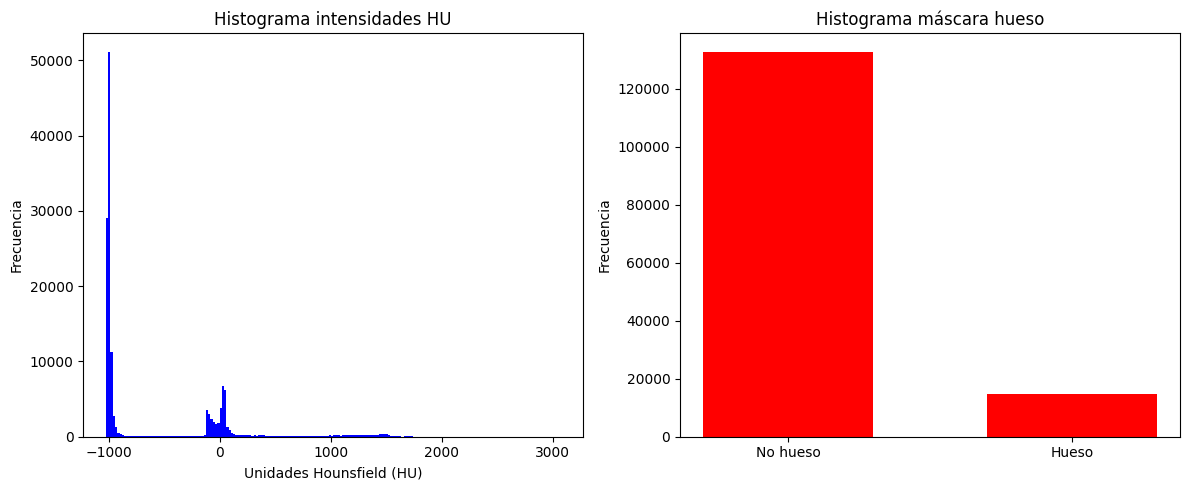

In [45]:
def show_histograms(volume, index=100, hu_bins=200, threshold=1000):
    coronal = np.flipud(volume[:, index, :])
    bone_mask = (coronal >= threshold).astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    print(bone_mask.ravel().shape)

    # Histograma HU
    axes[0].hist(coronal.ravel(), bins=hu_bins, color='blue')
    axes[0].set_title("Histograma intensidades HU")
    axes[0].set_xlabel("Unidades Hounsfield (HU)")
    axes[0].set_ylabel("Frecuencia")

    # Histograma hueso/no hueso
    axes[1].hist(bone_mask.ravel(), bins=[-0.5, 0.5, 1.5], rwidth=0.6, color='red')
    axes[1].set_title("Histograma máscara hueso")
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(["No hueso", "Hueso"])
    axes[1].set_ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

# Ejemplo
show_histograms(volume, index=120, hu_bins=200, threshold=80)


In [46]:
def bone_mask_stats(volume, index, threshold=1000):
    coronal = volume[:, index, :]
    coronal = np.flipud(coronal)
    bone_mask = (coronal >= threshold)

    n_total = bone_mask.size
    n_bone = np.sum(bone_mask == 1)
    n_non_bone = np.sum(bone_mask == 0)

    print(f"Total píxeles: {n_total}")
    print(f"No hueso (0): {n_non_bone}")
    print(f"Hueso (1): {n_bone}")
    print(f"Porcentaje hueso: {100*n_bone/n_total:.2f}%")

# Ejemplo
bone_mask_stats(volume, index=120, threshold=80)


Total píxeles: 147456
No hueso (0): 132684
Hueso (1): 14772
Porcentaje hueso: 10.02%
